**THIS TIME SERIES ANALYSIS IS DONE  ON CLOSING PRICE OF Historical S&P 500 index DATASET. FROM 2023 to 2025.**

Throughout the entire notebook we will focus on identifying trends , seasonal patterns and variance changes. 
if the data is non stationary inherently we will also try to convert the data from non stationary to stationary


THe analysis is done on the log returns column on the closing prices 
While dealing with financial data this is standard practice to analyze the log return column rather than the raw price series.***

In [ ]:
#import necessary libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
#BEgin with loading the dataset using yfinance library.

import yfinance as yf
import pandas as pd

#Download S&P 500 data
sp500 = yf.download('^GSPC', start='2022-05-23', end='2025-05-23')
sp500_df = sp500[['Close']].copy()

#Move date from index to column
sp500_df.reset_index(inplace=True)  
sp500_df.columns = ['Date', 'Closing_Price']

# Convert date again to index 
sp500_df.set_index('Date', inplace=True)
sp500_df

[*********************100%***********************]  1 of 1 completed


,Closing_Price
Date,
2022-05-23,3973.750000
2022-05-24,3941.479980
2022-05-25,3978.729980
2022-05-26,4057.840088
2022-05-27,4158.240234
...,...
2025-05-16,5958.379883
2025-05-19,5963.600098
2025-05-20,5940.459961


In [7]:
sp500_df.shape

(349, 1)

In [36]:
sp500_df.describe() 

,Closing_Price
count,350.000000
mean,5522.168828
std,375.264874
min,4688.680176
25%,5212.137695
50%,5565.800049
75%,5842.840088
max,6144.149902


In [ ]:
sp500_df.isnull().sum()

In [32]:
sp500_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 350 entries, 2024-01-02 to 2025-05-23
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Closing_Price  350 non-null    float64
 1   Year           350 non-null    int32  
 2   Month          350 non-null    int32  
dtypes: float64(1), int32(2)
memory usage: 8.2 KB


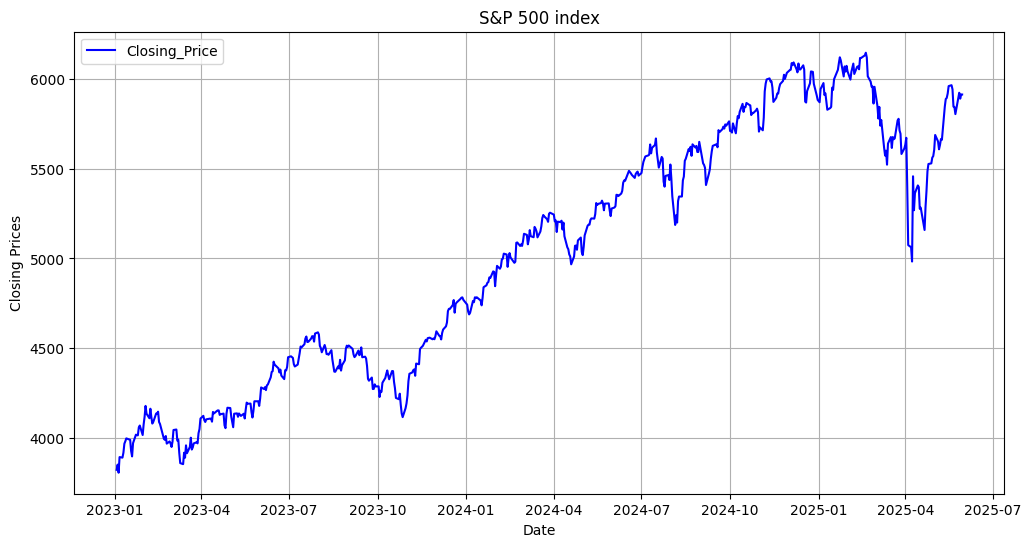

In [22]:
#Lets have a look at the graph Date vs closing Price

def plot_timeseries(df:pd.DataFrame,x_label,y_label,col):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[col], label=col, color="blue")
    plt.title("S&P 500 index")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.legend()
    plt.show()
plot_timeseries(sp500_df,"Date","Closing Prices","Closing_Price")




**Observation:** 
- There is no visually obvious repeating pattern at regular intervals (such as yearly, quarterly, or monthly cycles) that could indicate strong seasonality.
,any seasonality is not pronounced. The dominant feature  however is the trend, 
with some volatility and irregular cycles, rather than a clear seasonal component.

## Now we are going to perform seasonal decomposition.

### Things to Consider Before Seasonal Decomposition

- **Model Selection**
  - Decide whether an additive or multiplicative model is appropriate based on whether seasonal fluctuations remain constant (additive) or vary with the trend (multiplicative).[2][5]

- **Identify Seasonality Period**
  - Use domain knowledge, plots, autocorrelation, or spectral analysis to determine the correct seasonal period (e.g., 12 for monthly data, 7 for daily data with weekly seasonality).

- **Visual Inspection**
  - Plot your time series to visually check for trends, seasonality, and anomalies before decomposition.

- **Choose the Right Decomposition Method**
  - Select a decomposition technique (classical, STL, etc.) suited to your data and analysis goals.[2][5]

---

### Choosing the Right Seasonal Window

- **Too small a window:** Overfits noise, mistaking random fluctuations for seasonality.
- **Too large a window:** Oversmooths, missing real seasonal patterns and trend shifts.
- **Balance is key:** The window should be large enough to smooth out noise but small enough to capture genuine seasonality.


###  Techniques in Selecting an Appropriate Seasonal Window

- Use autocorrelation plots, periodograms, or Fourier transforms to identify dominant seasonal periods.
- Apply subsequence-based methods to capture local repetitive patterns.  
  *(Source: [AALTD22_paper_3876.pdf](https://project.inria.fr/aaltd22/files/2022/08/AALTD22_paper_3876.pdf


In [23]:
# lets begin with applying fourier transform , the Peaks in the frequency spectrum indicate dominant periodicities, which can be used to set the window size.
# first lets detrend the data to get more clarity since trend can mask periodic signals
test_sp500=sp500_df.copy()
test_sp500["Closing_Price"]=test_sp500["Closing_Price"].diff().dropna()
test_sp500=test_sp500.dropna()

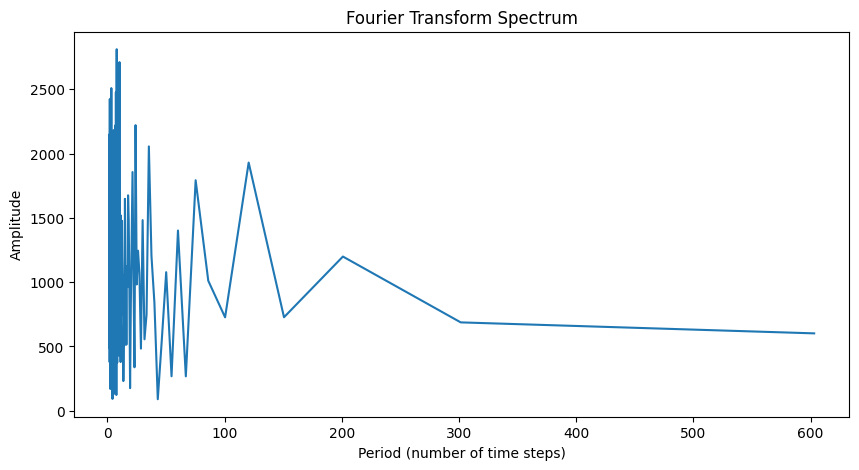

In [24]:
#The Fourier Transform decomposes your time series into a sum of sine and cosine waves of different frequencies. 
# The result is a spectrum showing which frequencies (periodicities) are most prominent.

import numpy as np
import matplotlib.pyplot as plt


data =test_sp500["Closing_Price"].values

# Compute the Fourier Transform
fft_vals = np.fft.fft(data)
fft_freq = np.fft.fftfreq(len(data))

# Only keep the positive frequencies
pos_mask = fft_freq > 0
fft_freq = fft_freq[pos_mask]
fft_power = np.abs(fft_vals[pos_mask])

# Plot the spectrum
plt.figure(figsize=(10, 5))
plt.plot(1/fft_freq, fft_power)
plt.xlabel('Period (number of time steps)')
plt.ylabel('Amplitude')
plt.title('Fourier Transform Spectrum')
plt.show() 

#The high amplitudes at low frequencies (first 50 points) mean your data has strong long-term trends or cycles. 
#The flatness at higher frequencies means there is little to no regular short-term seasonality or repeating patterns in your data after detrending.





C:\Users\injil\AppData\Local\Temp\ipykernel_18920\690317595.py:8: RuntimeWarning: divide by zero encountered in divide
  periods = np.where(freqs > 0, 1 / freqs, 0)


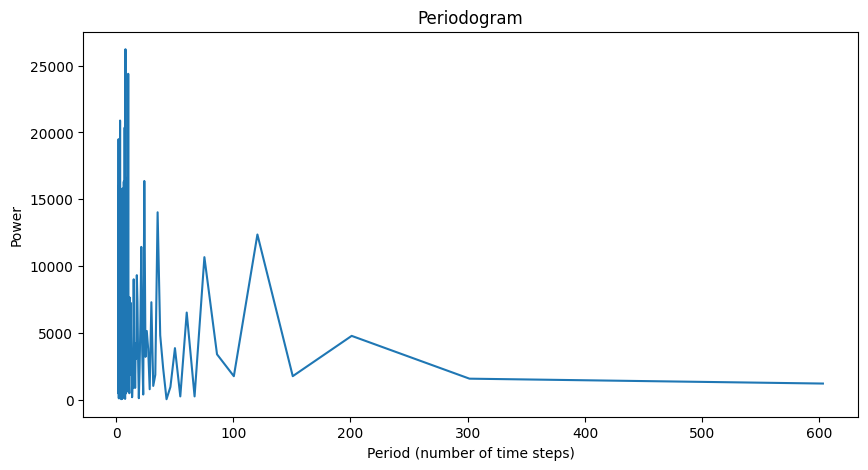

In [25]:
from scipy.signal import periodogram


fs = 1  # Sampling frequency (1 for regular time steps, adjust if needed)
freqs, power = periodogram(data, fs=fs)

# Convert frequency to period (avoid division by zero)
periods = np.where(freqs > 0, 1 / freqs, 0)

plt.figure(figsize=(10, 5))
plt.plot(periods[freqs > 0], power[freqs > 0])
plt.xlabel('Period (number of time steps)')
plt.ylabel('Power')
plt.title('Periodogram')
plt.show()


#The periodogram does not show any distinct, sharp peaks at higher periods that would indicate a 
# dominant seasonal cycle. Most of the power is concentrated at very low periods (high frequencies), 
# which typically reflects short-term fluctuations or noise, not seasonality.




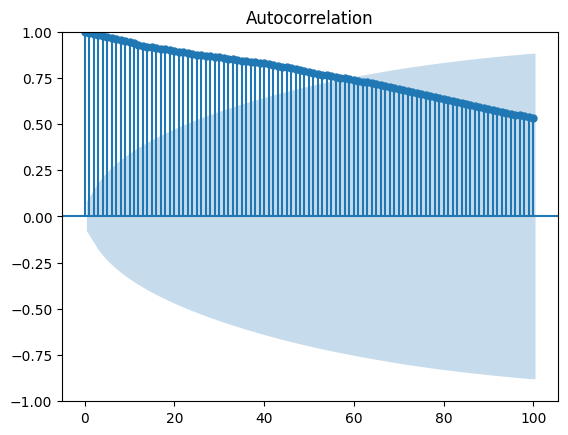

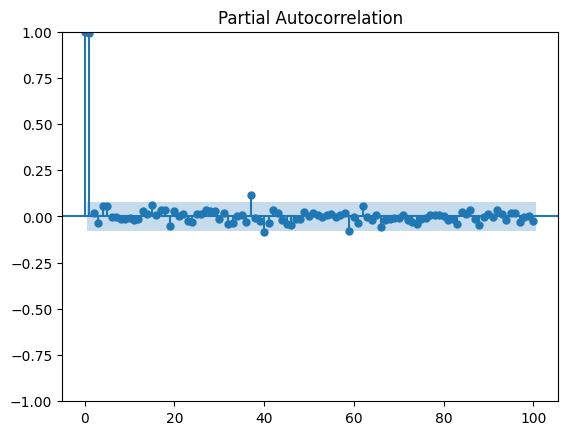

In [26]:

#Lets check the ACF and PACF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def plot_acf_pacf(df: pd.DataFrame):
            plot_acf(df["Closing_Price"].dropna(), lags=100)
            plot_pacf(df["Closing_Price"].dropna(), lags=100)
            plt.show()




plot_acf_pacf(sp500_df)


#The autocorrelation plot shows a slow, steady decay rather than pronounced spikes at specific lags 
# (such as at lag 12, 52, or 252), which would suggest regular seasonal patterns. Instead, the high autocorrelation
#  at short lags suggests strong trend or persistence, not seasonality


## Key Insights

- **No Clear Seasonality:**  
  The periodogram, ACF plot, and Fourier Transform spectrum all indicate a lack of strong or regular seasonality in the S&P 500 dataset.

- **Periodogram:**  
  No distinct peaks at higher periods; no dominant seasonal cycles detected.

- **ACF Plot:**  
  Gradual decay in autocorrelation, suggesting trend or persistence rather than repeating seasonal patterns.

- **Fourier Spectrum:**  
  Highest amplitudes at low periods (high frequencies), indicating short-term fluctuations, not seasonality.

**Conclusion:**  
There is no evidence to support a specific seasonal period for decomposition. The data is better characterized by trend and irregular fluctuations rather than seasonal cycles.


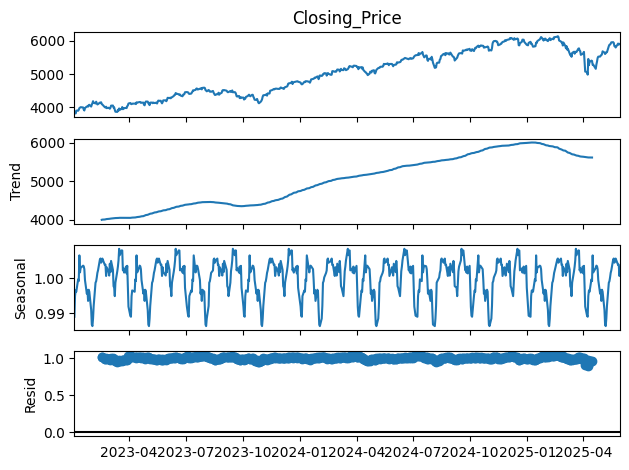

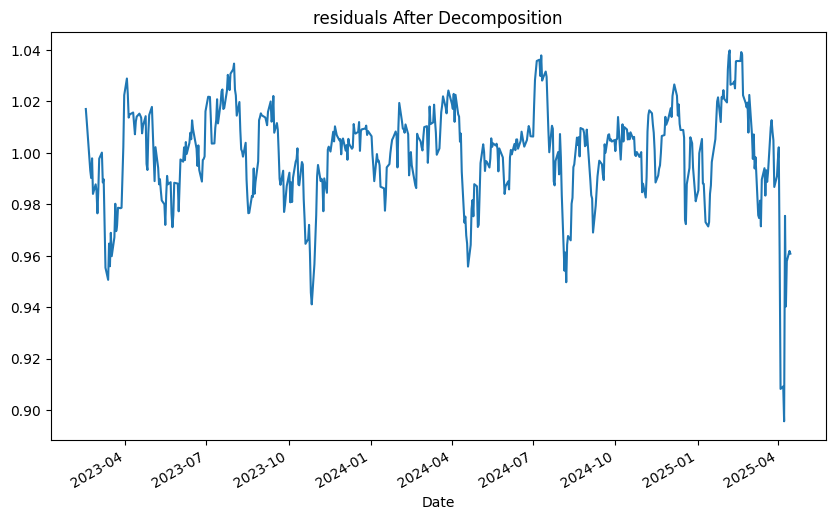

In [42]:

# Decompose the time series data


"""The additive decomposition is the most appropriate if the magnitude of the seasonal fluctuations, 
or the variation around the trend-cycle, does not vary with the level of the time series. 

When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be 
proportional to the level of the time series, then a multiplicative decomposition is more appropriate. 
"""


"""  
The residual can be formed by either subtracting out or dividing out the calculated trend and seasonality, 
depending on whether the target is assessed to have additive or multiplicative trend and seasonality respectively.
"""

def Seasonal_decompose(df:pd.DataFrame, model:str):
    
    result = seasonal_decompose(df["Closing_Price"], model=model, period=63) #63 is an assumption for a quarterly seasonality 
    result.plot()
    plt.show()
    residual = result.resid

    # Plot residuals
    residual.plot(figsize=(10, 6))
    plt.title("residuals After Decomposition")
  

Seasonal_decompose(sp500_df,"multiplicative")  

 


In [ ]:
 #Compute trend + seasonality for multiplicative and addiitve modeling
result = seasonal_decompose(sp500_df["Closing_Price"], model='additive', period=66) 

trend_seasonal = result.trend + result.seasonal

plt.figure(figsize=(14, 6))
plt.plot(sp500_df.index, sp500_df["Closing_Price"], label='Original Series', color='blue')
plt.plot(sp500_df.index, trend_seasonal, label='Trend + Seasonality', color='red')
plt.title('Original Series vs. Trend + Seasonality')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

result = seasonal_decompose(sp500_df["Closing_Price"], model='multiplicative', period=66) 

trend_seasonal = result.trend + result.seasonal

plt.figure(figsize=(14, 6))
plt.plot(sp500_df.index, sp500_df["Closing_Price"], label='Original Series', color='blue')
plt.plot(sp500_df.index, trend_seasonal, label='Trend + Seasonality', color='red')
plt.title('Original Series vs. Trend + Seasonality')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

---
simple decomposition methods have some drawbacks.

First, using a moving average to estimate the Trend + Cycle creates missing values for the first few and last values of the series. 


There are more robust methods like Seasonal and Trend decomposition using Loess - STL - that addresses some of these problems.



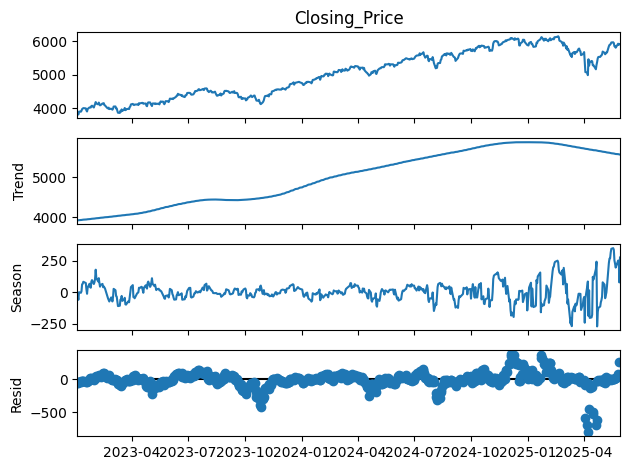

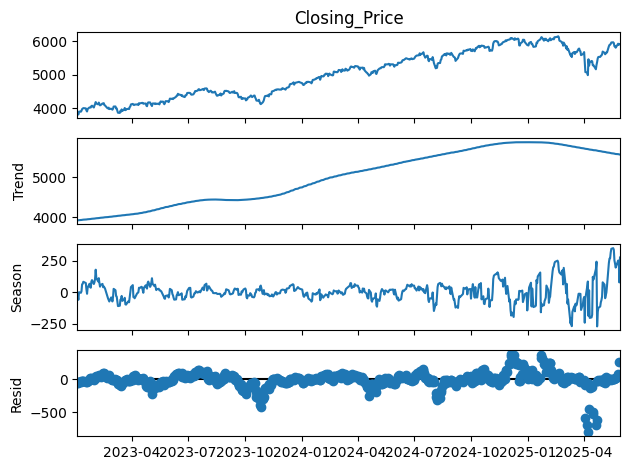

In [48]:




from statsmodels.tsa.seasonal import STL
stl = STL(sp500_df["Closing_Price"], period=63, robust=True)
res = stl.fit()
res.plot()


Text(0.5, 1.0, 'Residual Component')

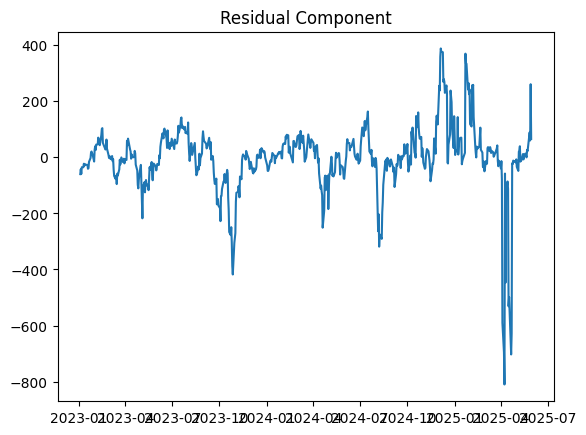

In [29]:
plt.plot(res.resid)
plt.title('Residual Component')
# the overly positve and negative residuals at the end suggest model overestimated  
# and underestimated some values at the end 

##  Residual Analysis Summary 

- THis applies for all the cases : Multiplicative , Addiitv and even STL decomposition

### 1. Heteroscedasticity


- Residual variance increases significantly over time.
- Early series: stable fluctuations.
- Later series (around 2025): large swings (e.g., +400 to -800).

**Conclusion**: Non-constant variance detected — classical models (like ARIMA) assumptions violated. 

---

### 2. Residual Pattern
- Residuals show persistent structure and clustering.
- Suggests non-randomness; possible autocorrelation.

**Conclusion**: Residuals are not white noise — trend/seasonality may not be fully captured.





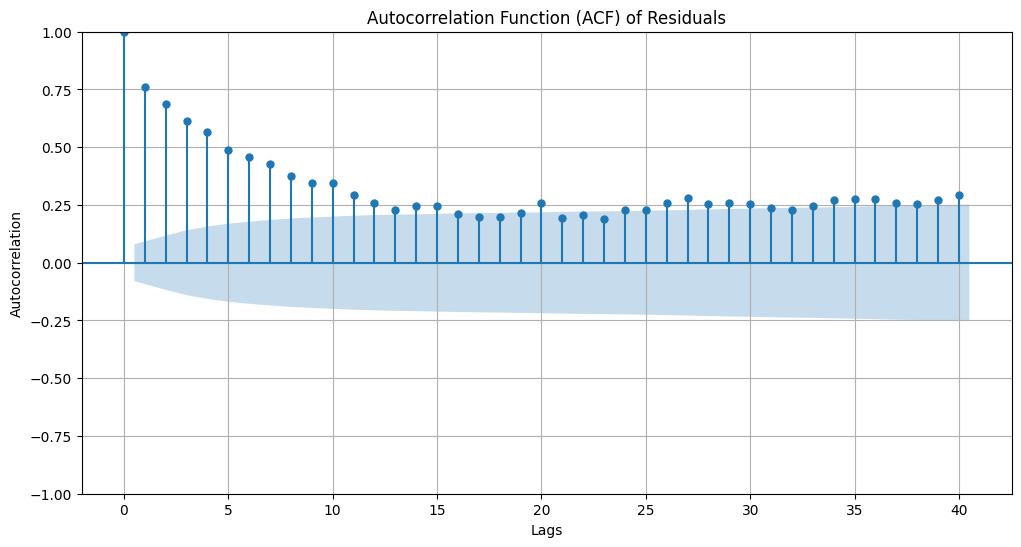

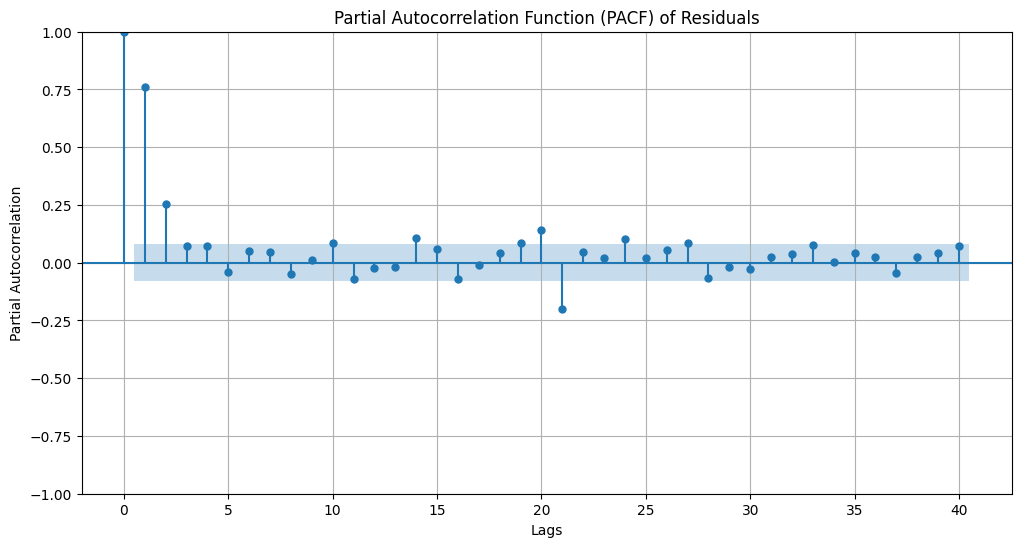

In [46]:
# Plotting ACF
import numpy as np
residuals= np.array(res.resid.values)
plt.figure(figsize=(12, 6))
plot_acf(residuals, lags=40, ax=plt.gca(), title='Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

# --- Plotting PACF ---
plt.figure(figsize=(12, 6))
plot_pacf(residuals, lags=40, ax=plt.gca(), title='Partial Autocorrelation Function (PACF) of Residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()


##  Interpretation of Residual ACF After STL Decomposition

### What the ACF Indicates:
- **Significant autocorrelation** in residuals suggests STL has **not fully captured** all the structure (especially trend or seasonality).
- Residuals should be approximately **white noise** if STL fully decomposed the time series — but yours are **not**.

---

###  What This Means for STL Decomposition:
- STL may have **underfit** the trend or seasonal component.
- This could be due to:
  - Incorrect seasonality period.
  - Complex or **non-constant seasonal patterns**.
  - Gradual **drift in seasonality** over time.



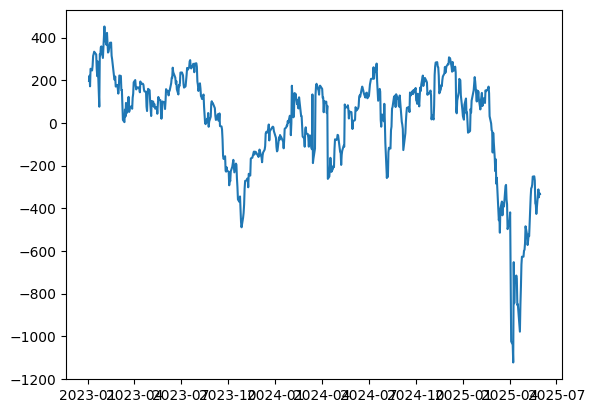

In [47]:
plt.plot(res.seasonal)


## STL Seasonal Component Analysis

- The seasonal component from STL decomposition does not show a clear, regular, or repeating seasonal pattern.
- Fluctuations are irregular and increase in volatility over time, suggesting noise or instability rather than seasonality.
- This supports the earlier conclusion that the S&P 500 data lacks strong seasonal cycles.


In [ ]:
trend_seasonal = res.trend + res.seasonal

plt.figure(figsize=(14, 6))
plt.plot(sp500_df.index, sp500_df["Closing_Price"], label='Original Series', color='blue')
plt.plot(sp500_df.index, trend_seasonal, label='Trend + Seasonality', color='red')
plt.title('Original Series vs. Trend + Seasonality')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [ ]:

from statsmodels.tsa.stattools import adfuller, kpss

result_adfuller = adfuller(sp500_df["Log_return"].dropna() )
print("ADF Statistic:", result_adfuller[0])
print("p-value:", result_adfuller[1])
print("Critical Values:", result_adfuller[4])# this prints the critical values as key_value pair 
if result_adfuller[0]>(result_adfuller[4])['5%']:
    print("The time seriess is Non_Stationary")
else:
    print("THe result is stationary")

We will create a new column called log returns
The 'log_returns' column tells us, for each day, the continuously compounded percentage change in the closing price compared to the previous day. 


**How to Interpret Log Returns:**

- Positive log return: The stock price increased from the previous day.

- Negative log return: The stock price decreased from the previous day.

**Value meaning:**
- A log return of 0.01 means the price increased by about 1% (on a continuously compounded basis).
- A log return of -0.02 means the price decreased by about 2%.
- For small values, we can interpret them roughly as percentage changes.


****Why Use Log Returns?****

- ***Statistical Properties***: Log returns are more likely to be normally distributed, which is a key assumption for many statistical and econometric models used in TSA.

- ***Compounding and Additivity:*** Log returns are time-additive, meaning you can sum log returns over multiple periods to get the total log return over that period. This property simplifies modeling and forecasting.

- ***Handling of Volatility:*** Log returns better accommodate the compounding nature of returns and are less affected by large price swings, making them more robust for modeling volatility and other time series properties.

- ***Stationarity:*** While taking logs alone does not guarantee stationarity, the series of log returns (i.e., first differences of log prices) is often much closer to stationary than the raw price series, which is a requirement for most TSA techniques

In [4]:

#This formula computes the natural logarithm of the ratio of each day's closing price to the previous day's closing price, which is the standard method for calculating log returns in financial analysis. 
# The result will be a new column where each entry (except the first, which will be NaN) represents the daily log return for that date.
sp500_df['Log_return'] = np.log(sp500_df['Closing_Price'] / sp500_df['Closing_Price'].shift(1))
sp500_df.head()

,Closing_Price,Log_return
Date,,
2022-05-23,3973.750000,NaN
2022-05-24,3941.479980,-0.008154
2022-05-25,3978.729980,0.009406
2022-05-26,4057.840088,0.019688
2022-05-27,4158.240234,0.024441


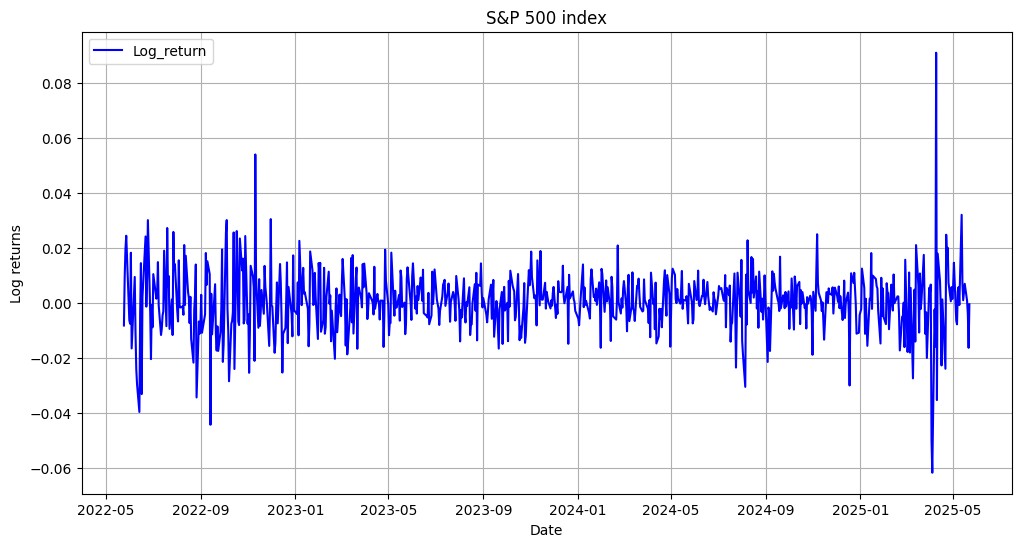

In [69]:
#plot Date vs Log_return

plot_timeseries(sp500_df,"Date","Log returns","Log_return")


- **Observation:**
The Log_return seems to have no trend at all however the comments on seasonality and varinace remain the same

Skewness: nan
Kurtosis: nan


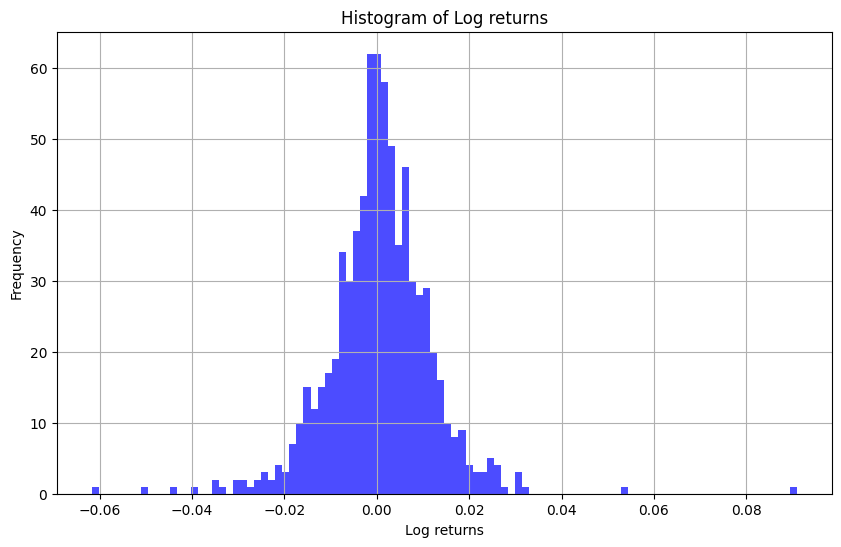

' the data is normally distributed now'

In [70]:

#have a check on the skewness of log_returns column

from scipy.stats import skew, kurtosis

skewness = skew(sp500_df["Log_return"])
kurt = kurtosis(sp500_df["Log_return"])
print("Skewness:", skewness) 
print("Kurtosis:", kurt)
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(sp500_df["Log_return"], bins=100, color='blue', alpha=0.7)
plt.title("Histogram of Log returns")
plt.xlabel("Log returns")
plt.ylabel("Frequency")        
plt.grid(True)         
plt.show()    


""" the data is normally distributed now"""

**Perform some checks on trend and seasonlaity.**

In [58]:
#Mann-Kendall test for presence of monotonic trend
#A monotonic  trend means that the variable consistently increases  or decreases through time, 
# but the trend may or may not be linear
#The trend does not have to be a straight line; it just must not change direction (no reversals from increasing to decreasing or vice versa)
"""
What Does the Mann-Kendall (pymannkendall) Test Do?
It tests the null hypothesis that there is no trend in the data.

The alternative hypothesis is that a monotonic trend (either increasing or decreasing) exists.

It is non-parametric: it does not assume any particular data distribution.

It is not designed to detect non-monotonic trends (such as cyclical, periodic, or trends that change direction)"""

import pymannkendall as mk
 

result = mk.original_test(sp500_df["Log_return"].dropna())
print(result)

Mann_Kendall_Test(trend='no trend', h=False, p=0.8771391542669265, z=-0.1545968489979269, Tau=-0.004214806366836912, s=-765.0, var_s=24422237.0, slope=-2.82959398006173e-07, intercept=0.0010011410872910245)


## Key Results and Interpretation

- **trend='no trend'**
There is no significant monotonic trend (neither increasing nor decreasing) detected in your time series data.

- **h=False**
The test failed to reject the null hypothesis. In other words, there is not enough evidence to say a trend exists.

- **p=0.8771**
A p-value much greater than 0.05 means the result is not statistically significant.
The  p-value (0.877) is very high, confirming there is no significant trend.

- **z=-0.1546**
This is the standardized test statistic.
Values close to 0 indicate no trend.


In [59]:
#test for presence of linear trend

import statsmodels.api as sm  #sm= statsmodel for stattistical analysis
sp500_df["Log_return"].dropna()

#Create a time index array (0, 1, 2, ..., N-1) corresponding to each non-NaN log return
time_index = np.arange(len(sp500_df["Log_return"].dropna()))

x = sm.add_constant(time_index) 

# Fit an Ordinary Least Squares (OLS) linear regression model: y = intercept + slope * time_index
y = sp500_df["Log_return"].dropna().values
model = sm.OLS(y, x).fit()

#This Prints the regression results summary, including coefficients, R-squared, p-values, etc.
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3672
Date:                Tue, 03 Jun 2025   Prob (F-statistic):              0.545
Time:                        16:21:39   Log-Likelihood:                 1920.3
No. Observations:                 603   AIC:                            -3837.
Df Residuals:                     601   BIC:                            -3828.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.410      0.1


## Key Results on Trend in S&P 500 Log Returns

- **No Significant Trend Detected:**  
  The slope coefficient is **-1.42e-06** (p = **0.545**), which is extremely close to zero and not statistically significant. This means there is no evidence of an upward or downward trend in log returns over time.

- **Model Explains Almost Nothing:**  
  The **R-squared is 0.001**, so the time trend explains only 0.1% of the variation in log returns—essentially none.

- **Average Log Return Not Significant:**  
  The intercept (average daily log return) is **0.0012** (p = **0.159**), which is not statistically different from zero.

- **Overall Model Not Significant:**  
  The F-statistic is **0.3672** with a p-value of **0.545**, confirming the model does not significantly explain the data.

---

### **Conclusion**

There is no statistically significant trend in the S&P 500 log returns over time (**slope ≈ 0, p = 0.545**). The model fits the data very poorly (**R-squared = 0.001**), and the average log return is not significant. This result is consistent with the Efficient Market Hypothesis, which suggests that returns are random and do not follow a predictable trend.

In [60]:
# Perform individual test for presence of seasonality

"""
The Friedman test is commonly used as a non-parametric test for detecting seasonality by comparing the medians of groups (such as months or quarters) across years.

The null hypothesis is that all periods (e.g., months) come from populations with equal medians—meaning there is no seasonality.

If the p-value is less than your significance level (commonly 0.05), you reject the null hypothesis and conclude that seasonality is present."""

from scipy.stats import friedmanchisquare

# Drop NaNs (e.g., from differencing)
values = sp500_df["Log_return"].dropna().values

# Ensure the length is divisible by 12 (e.g., complete years)
length = len(values) - (len(values) % 12)
values = values[:length]

# Reshape to (n_years, 12 months)
data = values.reshape(-1, 12)

# Apply Friedman test across columns (months)
stat, p = friedmanchisquare(*data.T)
print(f"Friedman p-value: {p:.6f}")  

# If p-value < 0.05, reject the null hypothesis of equal distributions across months
if p < 0.05:
    print("There are significant differences in the distributions of electric production across months, Means Seasonality exists.")   
else:
    print("No significant differences in the distributions of electric production across months, Seasonality does not exist.")

Friedman p-value: 0.240053
No significant differences in the distributions of electric production across months, Seasonality does not exist.


---
Since 0.240053 > 0.05 we fail to reject null hypothesis 

No significant seasonality detected:
The differences between periods (months, quarters, etc.) are not large enough to be considered statistically significant.

Interpretation:
Any apparent seasonal pattern in the  data could be due to random variation rather than a true, stable seasonal effect
Any observed differences could be due to random variation rather than a systematic effect.

In [72]:

from statsmodels.tsa.stattools import adfuller, kpss

result_adfuller = adfuller(sp500_df["Log_return"].dropna() )
print("ADF Statistic:", result_adfuller[0])
print("p-value:", result_adfuller[1])
print("Critical Values:", result_adfuller[4])# this prints the critical values as key_value pair 
if result_adfuller[0]>(result_adfuller[4])['5%']:
    print("The time seriess is Non_Stationary")
else:
    print("THe result is stationary")

ADF Statistic: -15.379446120684616
p-value: 3.42319010024073e-28
Critical Values: {'1%': -3.43912257105195, '5%': -2.8654117005229844, '10%': -2.568831705010152}
THe result is stationary


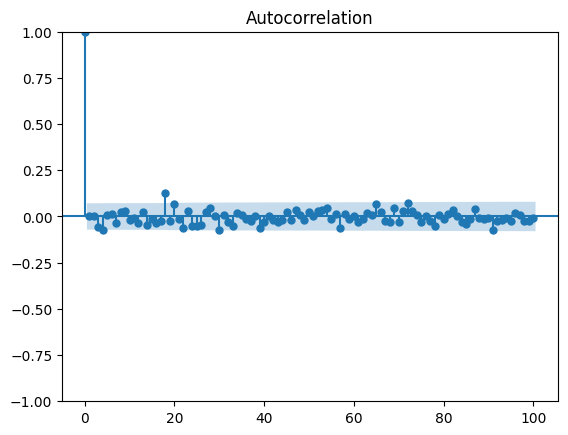

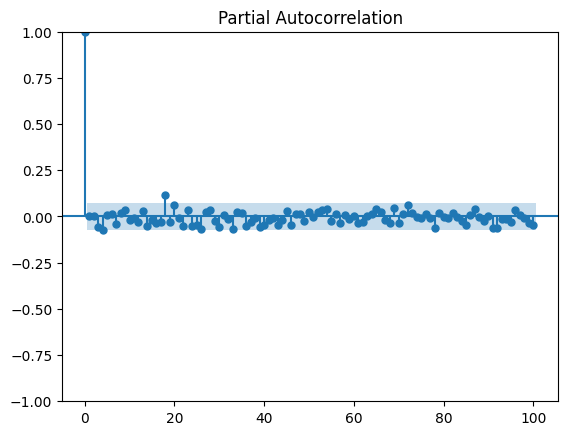

In [6]:

#Lets check the ACF and PACF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def plot_acf_pacf(df: pd.DataFrame):
            plot_acf(df["Log_return"].dropna(), lags=100)
            plot_pacf(df["Log_return"].dropna(), lags=100)
            plt.show()


plot_acf_pacf(sp500_df)


#The autocorrelation plot shows a slow, steady decay rather than pronounced spikes at specific lags 
# (such as at lag 12, 52, or 252), which would suggest regular seasonal patterns. Instead, the high autocorrelation
#  at short lags suggests strong trend or persistence, not seasonality


All the lags lie within the concfidence interval 

The log returns exhibit no linear autocorrelation, meaning past returns do not predict future returns in a linear way. 

This is consistent with the efficient market hypothesis (EMH), where asset prices reflect all available information, leaving returns unpredictable.

2Implications for ARIMA/SARIMA Modeling
ARIMA/SARIMA models rely on autocorrelation patterns (e.g., AR terms for lagged returns, MA terms for lagged errors) to forecast future values. If there is no autocorrelation:

AR terms (e.g., AR(1)) will be statistically insignificant.

MA terms may also lack significance unless residuals show nonlinear dependence.

The best ARIMA model may reduce to a white noise process (i.e., no structure to model).



THe above methods are not very clearly able to estimate the window size 
Lets Experiment with different window sizes and inspect the resulting seasonal component. Choose a size that captures meaningful, smooth patterns without overfitting noise.

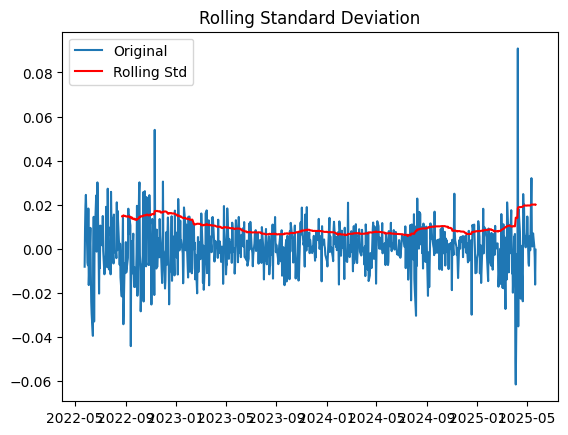

In [13]:
# checking for variance
def plot_rollingstd(df: pd.DataFrame):
    
        rolling_std = df["Log_return"].rolling(window=63).std()
        plt.plot(df["Log_return"], label='Original')
        plt.plot(rolling_std, label='Rolling Std', color='red')
        plt.legend()
        plt.title("Rolling Standard Deviation")
        plt.show() 

plot_rollingstd(sp500_df)
#For a stationary series, the rolling standard deviation should be roughly constant over time.



here the fluctuations are less but it might be because there is a trend in the data i.e mean is not constant .
#the true realtionship can be revealed if we remove the trend somehow



When a time series has a non-constant mean (trend), the rolling standard deviation calculated directly on the raw data may not accurately reflect changes in volatility or variance. The trend can artificially stabilize or suppress the fluctuations in the standard deviation,
making it seem more constant than it truly is.

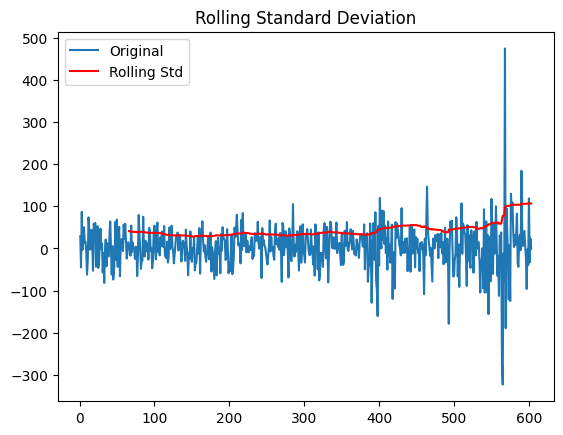

In [13]:
#If your rolling standard deviation is flat despite a trending mean, detrending the data will help somewhat  unveil any hidden changes in variance, allowing the rolling standard deviation to reflect the true variability in your time series.
#detrended_data=Log_transformed_data.copy()
detrended_data=sp500_df.copy()

detrended_data["Closing_Price"]=detrended_data["Closing_Price"].diff().dropna()
plot_rollingstd(detrended_data)


#Detrend values are the data with the trend component removed. 
# The detrend values are either the differences between the observed values and the trend values (additive model)
#  or the observed values divided by the trend values (multiplicative model). 
# If the plot of the detrend data looks different from the original data, 
# you can conclude that a trend component exists in the data.


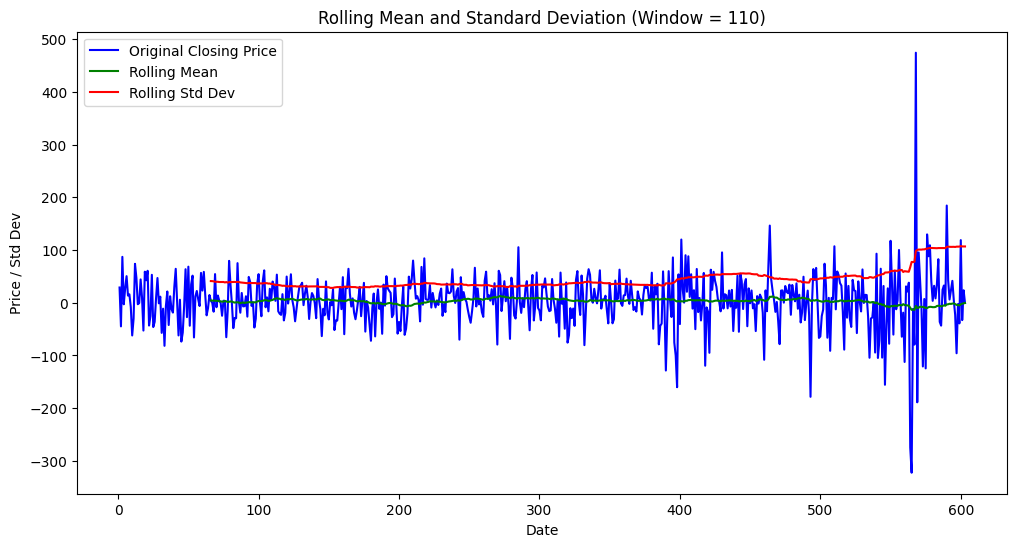

In [14]:
import matplotlib.pyplot as plt

window_size = 66

def plot_rollin_mean_vs_std(df):

                        #Calculate rolling mean and rolling std deviation
                        rolling_mean = df["Closing_Price"].rolling(window=window_size).mean()
                        rolling_std = df["Closing_Price"].rolling(window=window_size).std()

                        # Plot original series, rolling mean, and rolling std
                        plt.figure(figsize=(12, 6))
                        plt.plot(df["Closing_Price"], label='Original Closing Price', color='blue')
                        plt.plot(rolling_mean, label='Rolling Mean', color='green')
                        plt.plot(rolling_std, label='Rolling Std Dev', color='red')
                        plt.legend()
                        plt.title("Rolling Mean and Standard Deviation (Window = 110)")
                        plt.xlabel("Date")
                        plt.ylabel("Price / Std Dev")   
                        plt.show()
plot_rollin_mean_vs_std(detrended_data)


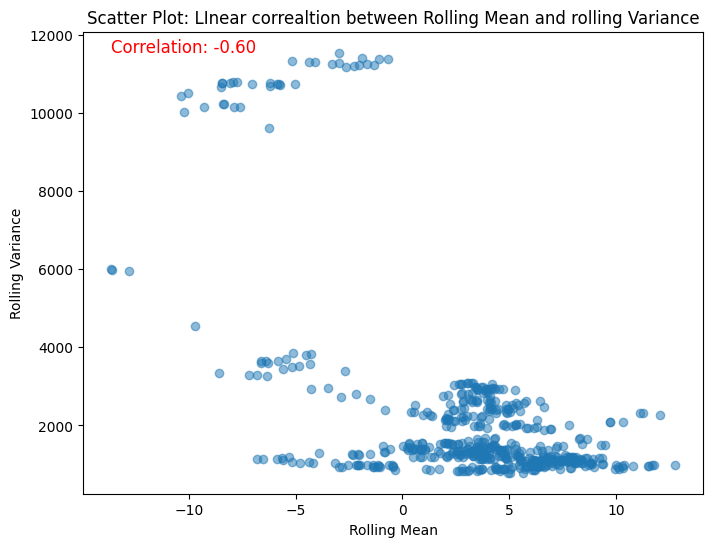

In [15]:
import matplotlib.pyplot as plt
import numpy as np
def plot_corr(df):
            # Calculate rolling mean and variance
            rolling_mean = df["Closing_Price"].rolling(window=66).mean()
            rolling_var = df["Closing_Price"].rolling(window=66).var()

            # Drop NaN values resulting from rolling calculationszzzzzz
            rolling_mean = rolling_mean.dropna()
            rolling_var = rolling_var.dropna()

            # Scatter plot
            plt.figure(figsize=(8,6))
            plt.scatter(rolling_mean, rolling_var, alpha=0.5)
            plt.xlabel('Rolling Mean')
            plt.ylabel('Rolling Variance')
            plt.title('Scatter Plot: LInear correaltion between Rolling Mean and rolling Variance')

            # Calculate correlation coefficient
            corr = np.corrcoef(rolling_mean, rolling_var)[0,1]

            # Display correlation coefficient on the plot
            plt.text(min(rolling_mean), max(rolling_var), f'Correlation: {corr:.2f}', fontsize=12, color='red')
            plt.show()
plot_corr(detrended_data)



the above graphs suggest some relation between mean and std dev ...a linear negative correaltion of 60% but this may or may not be real ....Lets begin with removing seasonality and check the plots again.

In [17]:
"""Seasonally adjusted values are the data with the seasonal component removed. 
The seasonally adjusted values are either the differences between the observed values and the seasonal values 
(additive model) or the observed values divided by the seasonal values (multiplicative model). 
If the plot of the seasonally adjusted data looks different from the original data, you can conclude that a 
seasonal component exists in the data."""

Seas_adj_data=Log_transformed_data.copy()
Seas_adj_data["Closing_Price"] = Seas_adj_data["Closing_Price"] - Seas_adj_data["Closing_Price"].shift(66)
Seas_adj_data=Seas_adj_data.dropna()






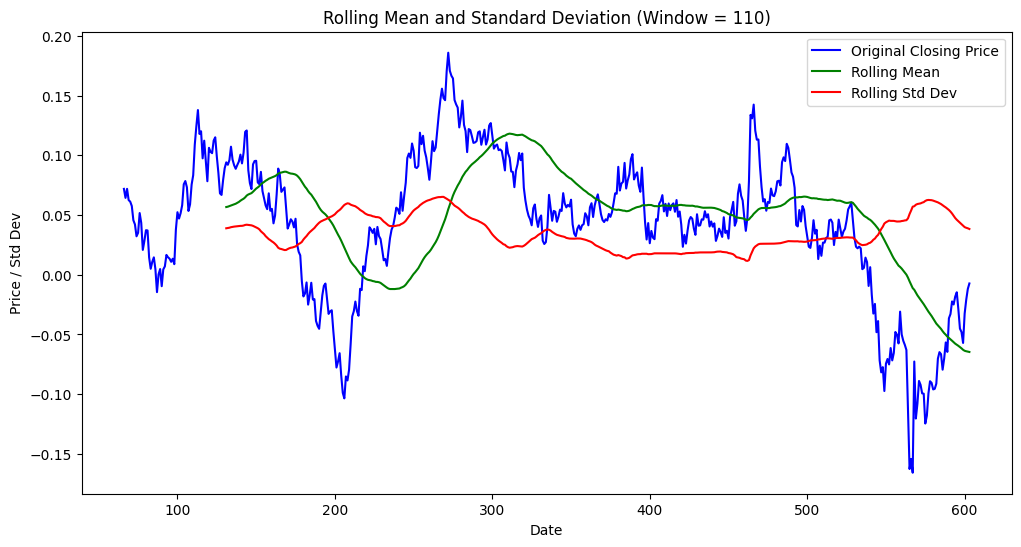

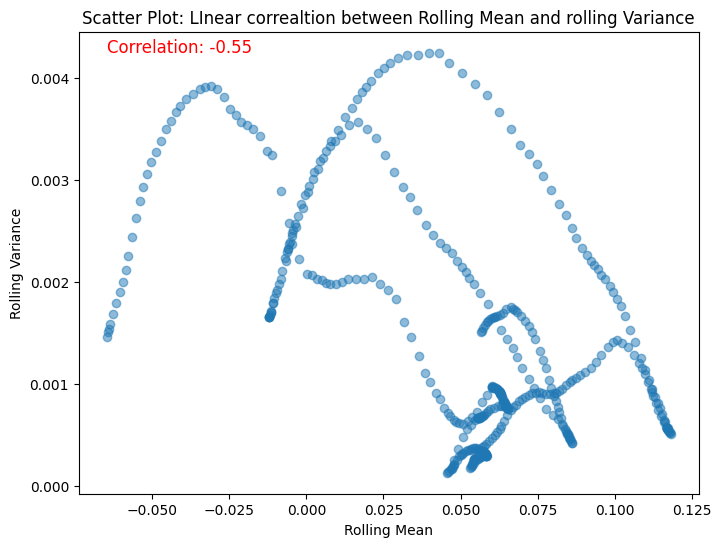

In [18]:

plot_rollin_mean_vs_std(Seas_adj_data)
plot_corr(Seas_adj_data)

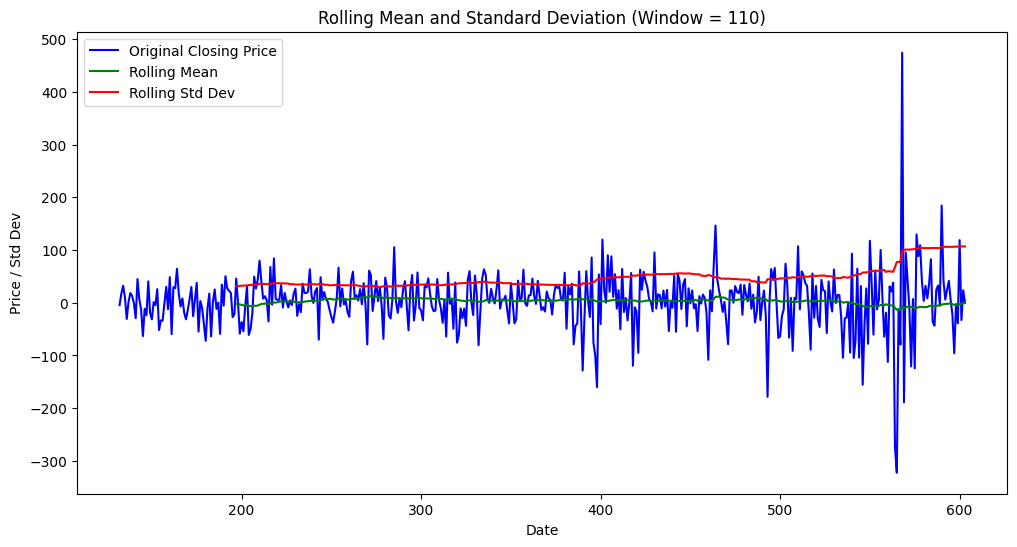

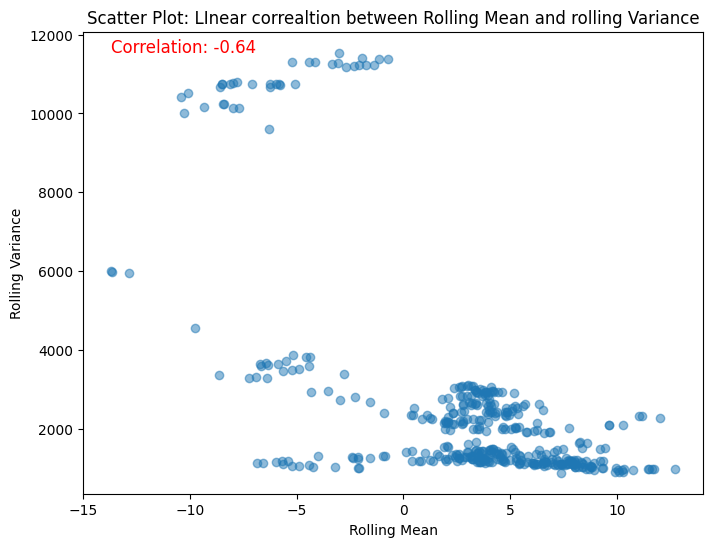

In [19]:
"""Seas. Adj. and Detr. Data
The seasonally adjusted and detrend values are also called residuals. The residuals are the differences between 
the observed values and the predicted values. Examine the plot to determine whether your model is adequate. 
The residuals should be randomly distributed with no obvious patterns and no unusual values."""
Seas_adj_detr_data =detrended_data.copy()
Seas_adj_detr_data["Closing_Price"] = Seas_adj_detr_data["Closing_Price"] - Seas_adj_data["Closing_Price"].shift(66)
Seas_adj_detr_data=Seas_adj_detr_data.dropna()


plot_rollin_mean_vs_std(Seas_adj_detr_data)
plot_corr(Seas_adj_detr_data)

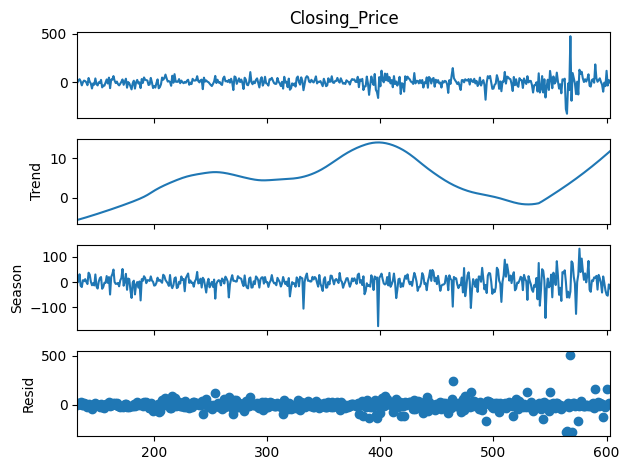

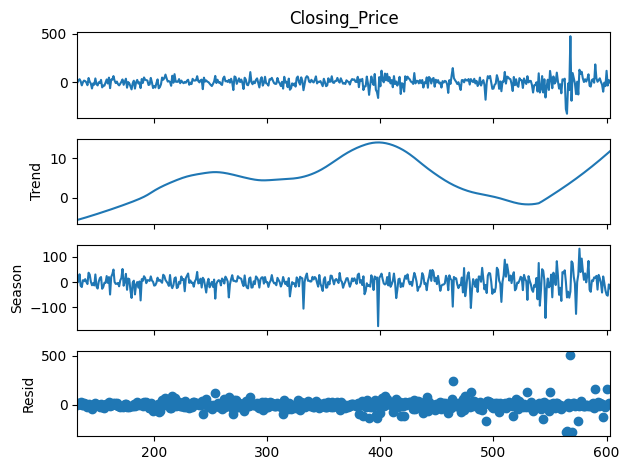

In [20]:

from statsmodels.tsa.seasonal import STL
stl = STL(Seas_adj_detr_data["Closing_Price"], period=66, robust=True)
res = stl.fit()
res.plot()

Text(0.5, 1.0, 'Residual Component')

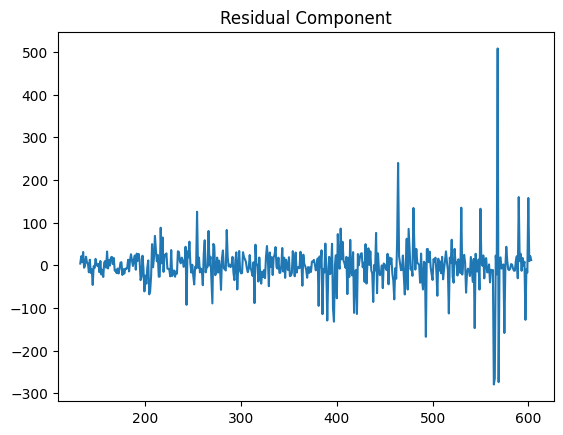

In [22]:
plt.plot(res.resid)
plt.title('Residual Component')

In [ ]:
#Extract both year and month from the datetime index

#Monthly Average Closing Price (Month-wise)

sp500_df["Month"] = sp500_df.index.month

#Group by Year and Month
monthly_mean = sp500_df.groupby(["Month"])["Closing_Price"].mean()

# Convert to a DataFrame for easier plotting
monthly_mean = monthly_mean.reset_index()

# Optional: create a 'Year-Month' column for plotting
monthly_mean["Month"] = pd.to_datetime(monthly_mean["Month"].astype(str) + "-" + monthly_mean["Month"].astype(str))

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
plt.plot(monthly_mean["Month"], monthly_mean["Closing_Price"])
plt.title("Monthly Average Closing Price (Year-wise)")
plt.xlabel("Date")
plt.ylabel("Average Closing Price")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
from scipy.stats import boxcox


# Apply Box-Cox transformation
sp500_df["Closing_Price"], lambda_val = boxcox(sp500_df["Closing_Price"])


Perform tests on seasoanlly adj and detrended data to check for staionarity

In [23]:

from statsmodels.tsa.stattools import adfuller, kpss

result_adfuller = adfuller(Seas_adj_detr_data["Closing_Price"] )
print("ADF Statistic:", result_adfuller[0])
print("p-value:", result_adfuller[1])
print("Critical Values:", result_adfuller[4])# this prints the critical values as key_value pair 
if result_adfuller[0]>(result_adfuller[4])['5%']:
    print("The time seriess is Non_Stationary")
else:
    print("THe result is stationary")

ADF Statistic: -12.51070508357172
p-value: 2.678299244743503e-23
Critical Values: {'1%': -3.4444002781824477, '5%': -2.867735576537528, '10%': -2.57007000456571}
THe result is stationary


Individual check for presence of monotonic trend(linear)

In [24]:
import pymannkendall as mk
# Perform Mann-Kendall test

result = mk.original_test(Seas_adj_detr_data["Closing_Price"].dropna())
print(result)

Mann_Kendall_Test(trend='no trend', h=False, p=0.5655972649128196, z=0.5745476509626917, Tau=0.017704847241714346, s=1968.0, var_s=11720782.666666666, slope=0.008262703009722372, intercept=3.2866419068486437)


Individual check for presence of seasonality

In [25]:
from scipy.stats import friedmanchisquare

# Drop NaNs (e.g., from differencing)
values = Seas_adj_detr_data["Closing_Price"].dropna().values

# Ensure the length is divisible by 12 (e.g., complete years)
length = len(values) - (len(values) % 12)
values = values[:length]

# Reshape to (n_years, 12 months)
data = values.reshape(-1, 12)

# Apply Friedman test across columns (months)
stat, p = friedmanchisquare(*data.T)
print(f"Friedman p-value: {p:.6f}")  

# If p-value < 0.05, reject the null hypothesis of equal distributions across months
if p < 0.05:
    print("There are significant differences in the distributions of electric production across months, Means Seasonality exists.")   
else:
    print("No significant differences in the distributions of electric production across months, Seasonality does not exist.")

Friedman p-value: 0.089149
No significant differences in the distributions of electric production across months, Seasonality does not exist.


In [26]:
"""
ARCH Test (Autoregressive Conditional Heteroskedasticity Test)

The ARCH test is a statistical test used to detect the presence of autoregressive conditional heteroskedasticity (ARCH) effects in a time series. 
ARCH effects indicate that the variance of the current error term or innovation is related to the variances of previous time periods' error terms, 
which is common in financial and economic time series.

How it works:
- The test fits a regression model to the squared residuals of a time series.
- It checks whether past squared residuals can explain the current squared residual.
- If the test statistic is significant (low p-value), it suggests the presence of ARCH effects (time-varying volatility).

Use case:
- The ARCH test is commonly used before fitting GARCH or other volatility models to determine if modeling conditional heteroskedasticity is necessary.

Hypotheses:
- Null Hypothesis (H0): No ARCH effects (homoskedasticity; constant variance).
- Alternative Hypothesis (H1): Presence of ARCH effects (heteroskedasticity; time-varying variance).
Interpretation:
- A p-value less than the chosen significance level (e.g., 0.05) indicates rejection of the null hypothesis, suggesting the presence of ARCH effects.
"""


# ARCH test
from statsmodels.stats.diagnostic import het_arch
arch_test = het_arch(Seas_adj_detr_data["Closing_Price"].dropna())
if arch_test[1]<0.05: 
    print("Arch effects present")
else:
    print("Arch effects not present")

print("P-value: ", arch_test[1])

Arch effects present
P-value:  1.3909262879734347e-15


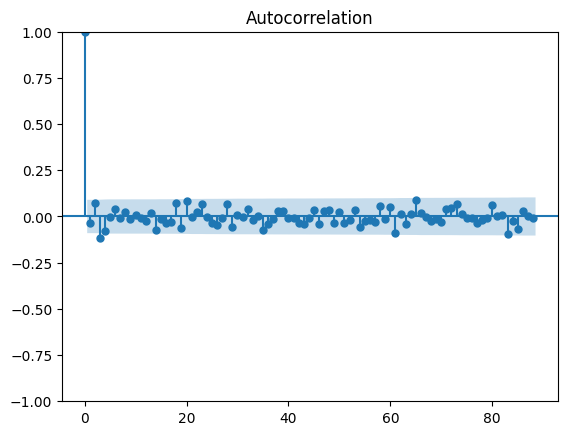

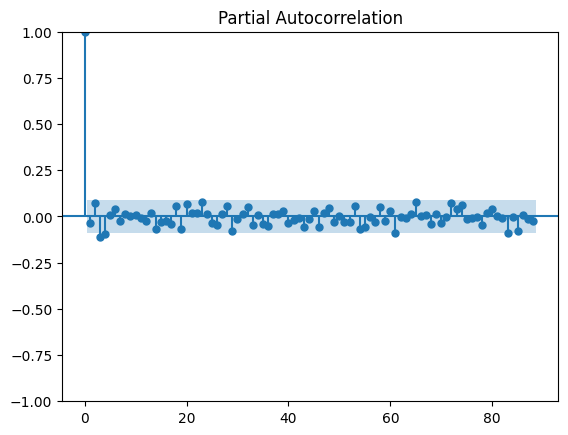

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(Seas_adj_detr_data["Closing_Price"].dropna(), lags=88)

plot_pacf(Seas_adj_detr_data["Closing_Price"].dropna(), lags=88)


plt.show()


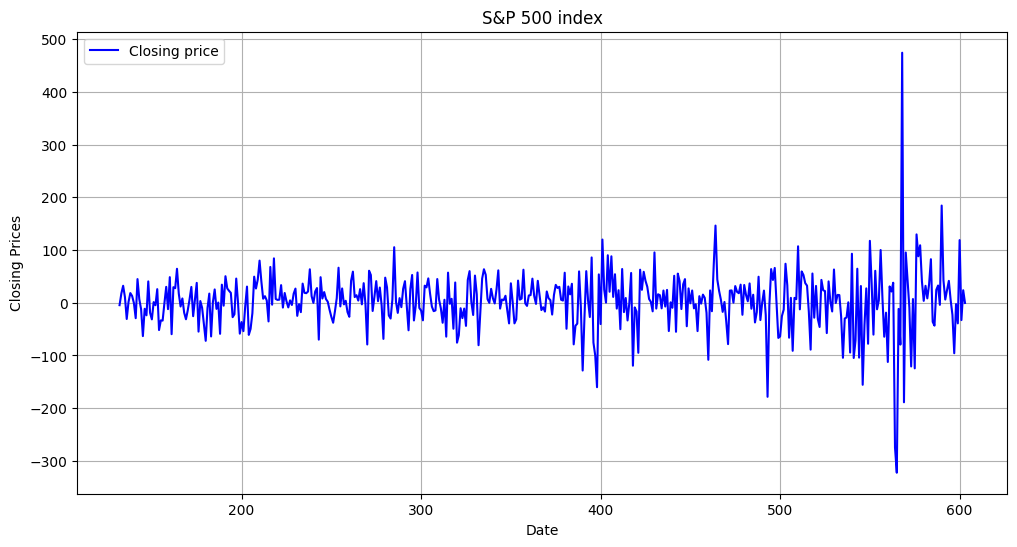

In [28]:
plot_timeseries(Seas_adj_detr_data)

In [29]:
""" 
Coefficients:

mu: This is the constant term in the mean equation (if you included one). It represents the average value of the series.
omega: This is the constant term in the variance equation. It's the long-run average variance. It must be positive.
alpha[1]: This is the coefficient on the lagged squared residual (the ARCH term). It indicates how much the previous period's shock affects current volatility. It should be positive and less than 1.
beta[1]: This is the coefficient on the lagged conditional variance (the GARCH term). It indicates how much the previous period's volatility affects current volatility. It should be positive and less than 1.
alpha[1] + beta[1]: The sum of these coefficients is crucial. If it's close to 1, it suggests that volatility is very persistent (it takes a long time for shocks to die out). If it's greater than or equal to 1, the model is not stationary, which is a problem.
Significance (P-values):

Look at the p-values associated with each coefficient. A small p-value (typically less than 0.05) indicates that the coefficient is statistically significant, meaning it's unlikely to be zero. Significant coefficients are important for the model.
Model Fit Statistics:

Log-Likelihood: A higher log-likelihood generally indicates a better fit.
AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion): These are used to compare different models. Lower values indicate a better trade-off between model fit and complexity. If you're comparing different GARCH models (e.g., different orders), use these to help choose the best one.
Diagnostics:

Jarque-Bera Test: This tests whether the residuals are normally distributed. GARCH models assume that the standardized residuals (residuals divided by the conditional standard deviation) are normally distributed. A significant p-value here suggests non-normality, which might indicate a problem with the model or the need for a different distribution.
Ljung-Box Test: This tests for autocorrelation in the residuals and squared residuals. Significant autocorrelation suggests that the model is not capturing all the dependence in the data. If there is autocorrelation in the squared residuals, it suggests that there is still ARCH effect in the residuals, and the model is not correctly specified.
Warnings:

Pay attention to any warnings that the arch library might produce. These warnings can indicate potential problems with the model, such as non-stationarity or convergence issues.
In summary, you're looking for: significant coefficients that make sense in the context of your data, a good model fit (as indicated by the AIC/BIC), and no major violations of the model's assumptions (as indicated by the diagnostic tests).

"""



from arch import arch_model

series =Seas_adj_detr_data["Closing_Price"].dropna()


# Fit GARCH(1,1)
model = arch_model(series, vol='Garch', p=1, q=1)
res = model.fit(disp="off")
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:          Closing_Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2479.49
Distribution:                  Normal   AIC:                           4966.98
Method:            Maximum Likelihood   BIC:                           4983.61
                                        No. Observations:                  472
Date:                Sun, Jun 01 2025   Df Residuals:                      471
Time:                        13:04:29   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             3.6417      1.878      1.940  5.243e-02 [-3.83

In [24]:

ts =Seas_adj_detr_data["Closing_Price"]
train = ts[:463]
test = ts[463:]  

In [25]:
Seas_adj_detr_data.shape

(599, 1)

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller




model = ARIMA(train, order=(0,0,1))  # choose your (p,d,q)
fitted_model = model.fit()
print(fitted_model.summary())
# 4. Forecast same number of steps as test set
forecast = fitted_model.forecast(steps=len(test))




                               SARIMAX Results                                
Dep. Variable:          Closing_Price   No. Observations:                  463
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -2342.898
Date:                Sat, 31 May 2025   AIC                           4691.797
Time:                        18:52:38   BIC                           4704.210
Sample:                             0   HQIC                          4696.684
                                - 463                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2301      1.845      2.293      0.022       0.615       7.845
ma.L1         -0.0019      0.043     -0.044      0.965      -0.086       0.082
sigma2      1454.8679     81.998     17.743      0.0

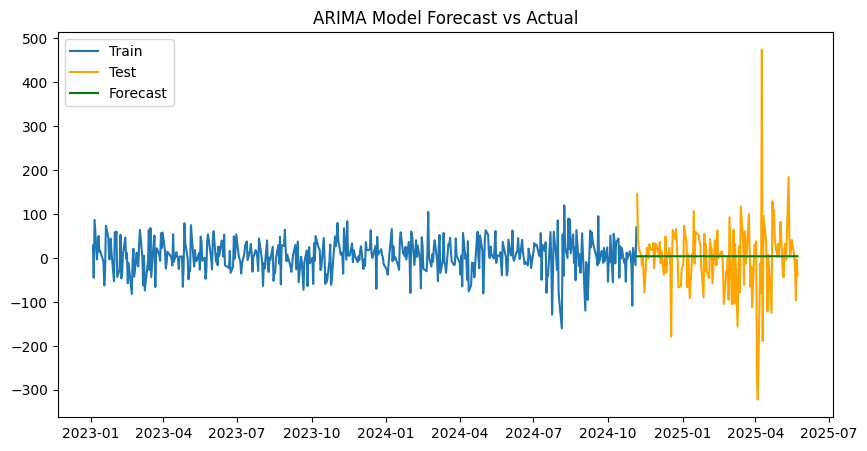

Test MAE: 52.37
Test RMSE: 81.58


In [32]:
# 5. Plot forecast vs actual
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

plt.figure(figsize=(10, 5))
plt.plot(train, label="Train")
plt.plot(test, label="Test", color='orange')
plt.plot(test.index, forecast, label="Forecast", color='green')
plt.legend()
plt.title("ARIMA Model Forecast vs Actual")
plt.show()

# 6. Evaluate performance
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[66] intercept   : AIC=inf, Time=45.18 sec
 ARIMA(0,0,0)(0,0,0)[66] intercept   : AIC=4689.798, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[66] intercept   : AIC=4692.961, Time=7.96 sec
 ARIMA(0,0,1)(0,0,1)[66] intercept   : AIC=4693.036, Time=9.71 sec
 ARIMA(0,0,0)(0,0,0)[66]             : AIC=4693.459, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[66] intercept   : AIC=4690.961, Time=7.14 sec
 ARIMA(0,0,0)(0,0,1)[66] intercept   : AIC=4691.037, Time=2.87 sec
 ARIMA(0,0,0)(1,0,1)[66] intercept   : AIC=inf, Time=20.36 sec
 ARIMA(1,0,0)(0,0,0)[66] intercept   : AIC=4691.797, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[66] intercept   : AIC=4691.797, Time=0.29 sec
 ARIMA(1,0,1)(0,0,0)[66] intercept   : AIC=inf, Time=1.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[66] intercept
Total fit time: 94.872 seconds

Best SARIMA model order: (0, 0, 0) Seasonal Order: (0, 0, 0, 66)


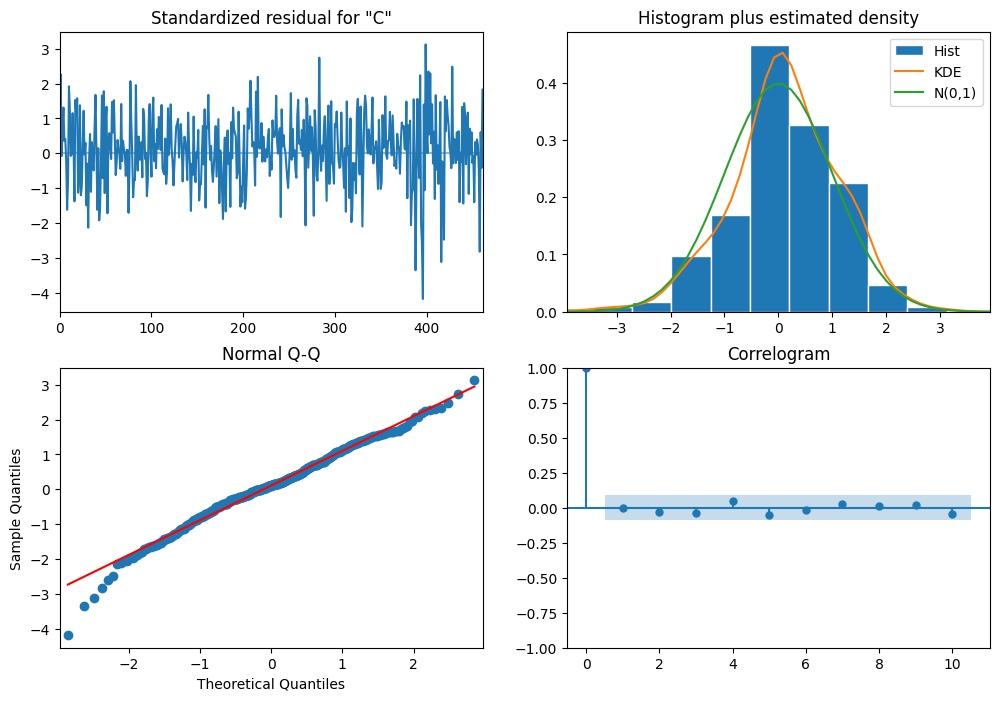

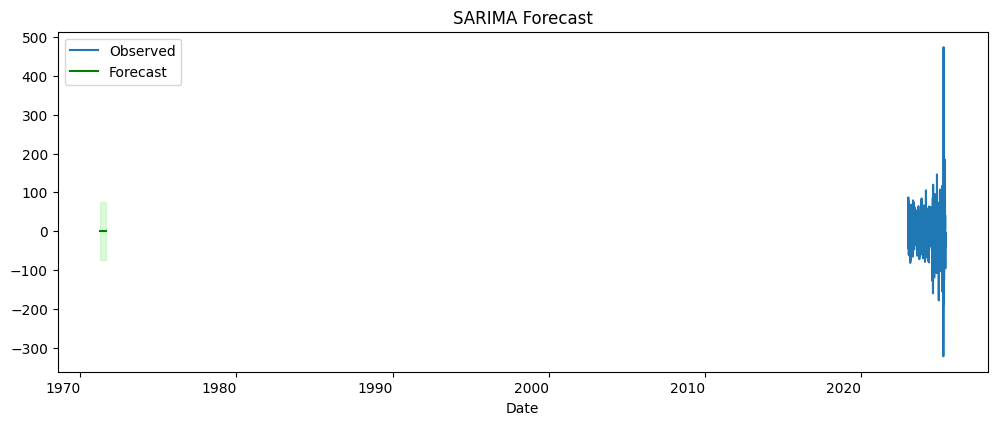

In [28]:


from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")






stepwise_model = auto_arima(train,
                             seasonal=True, m=66, 
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

print(f"\nBest SARIMA model order: {stepwise_model.order} Seasonal Order: {stepwise_model.seasonal_order}")


model = SARIMAX(train,
                order=stepwise_model.order,
                seasonal_order=stepwise_model.seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)

# Step 6: Model diagnostics
results.plot_diagnostics(figsize=(12, 8))
plt.show()

# Step 7: Forecast future values
n_forecast = len(test) 


forecast = results.get_forecast(steps=n_forecast)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot the forecast
ax = ts.plot(label='Observed', figsize=(12, 5))
forecast.predicted_mean.plot(ax=ax, label='Forecast', color='green')
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='lightgreen', alpha=0.3)
plt.legend()
plt.title("SARIMA Forecast")          
plt.show()


In [17]:


train = sp500_df[:516]
test =sp500_df[516:]  

In [9]:
sp500_df.shape

(604, 2)

12:45:54 - cmdstanpy - INFO - Chain [1] start processing
12:45:54 - cmdstanpy - INFO - Chain [1] done processing


            ds         yhat   yhat_lower   yhat_upper
0   2023-01-03  3927.061772  3853.119660  4006.909774
1   2023-01-04  3918.998223  3840.354102  4000.283139
2   2023-01-05  3916.433002  3839.407443  3995.071288
3   2023-01-06  3918.057280  3839.478903  3996.399126
4   2023-01-09  3913.375121  3833.944188  3989.505498
..         ...          ...          ...          ...
599 2025-04-17  6072.756504  5900.580186  6220.355075
600 2025-04-18  6072.456319  5908.829340  6227.300733
601 2025-04-19  6001.160266  5837.296341  6160.130348
602 2025-04-20  5997.720643  5827.234805  6151.583163
603 2025-04-21  6059.490685  5889.126846  6215.607364

[604 rows x 4 columns]


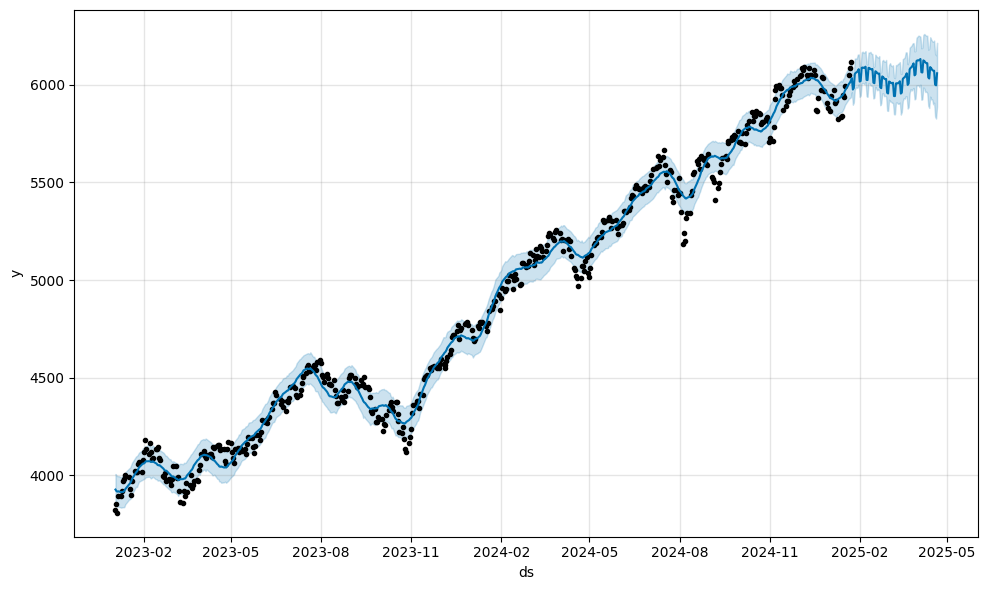

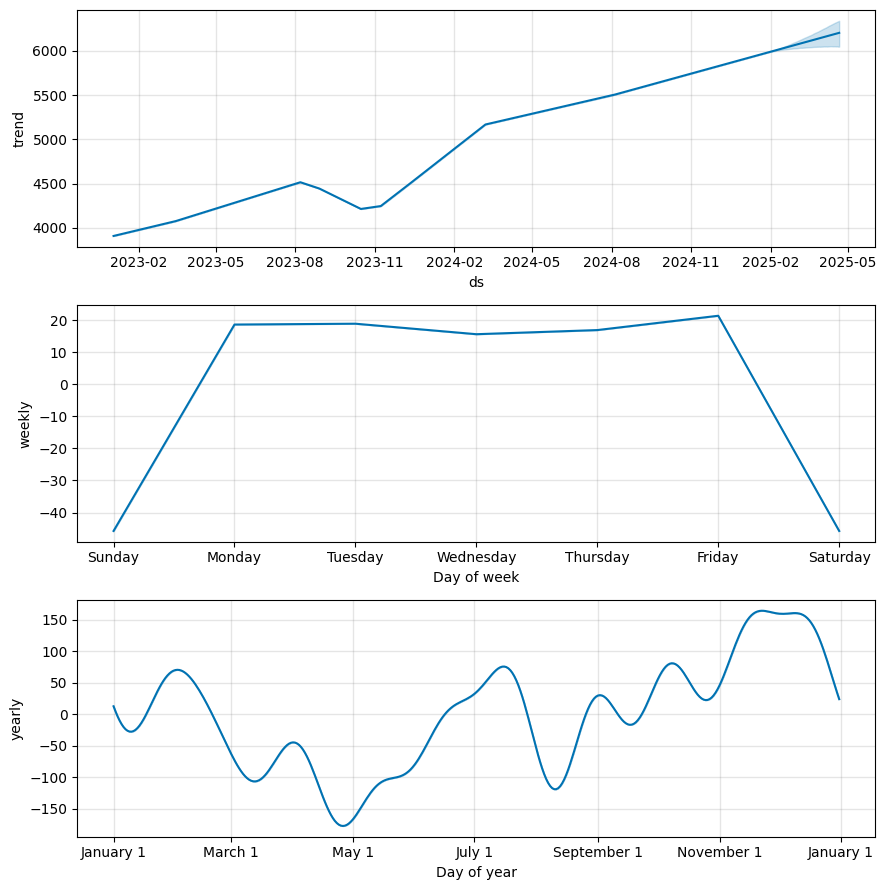

In [18]:
import pandas as pd
from prophet import Prophet

# Load your data into a DataFrame
# DataFrame must have columns 'ds' (date) and 'y' (value)

# Initialize and fit the model
model = Prophet()
model.fit(train)

# Create a DataFrame for future dates
future = model.make_future_dataframe(periods=88)  # e.g., forecast 1 year ahead

# Generate forecast
forecast = model.predict(future)

# View forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)


from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)
plot_components_plotly(model, forecast)


In [6]:
sp500_df = sp500_df.rename(columns={"Date":"ds","Closing_Price":"y"})


In [9]:
sp500_df.shape

(600, 2)

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(test['y'], predicted_forecast['yhat'])
mse = mean_squared_error(test['y'], predicted_forecast['yhat'])
r2 = r2_score(test['y'], predicted_forecast['yhat'])

print(f'MAE: {mae}, MSE: {mse}, R2: {r2}')


MAE: 320.9300716629903, MSE: 166542.24323454863, R2: -1.1997826027789746


In [19]:
predicted_forecast = forecast.iloc[516:,:]


In [20]:
test.shape

(88, 2)

In [21]:
predicted_forecast.shape


(88, 19)

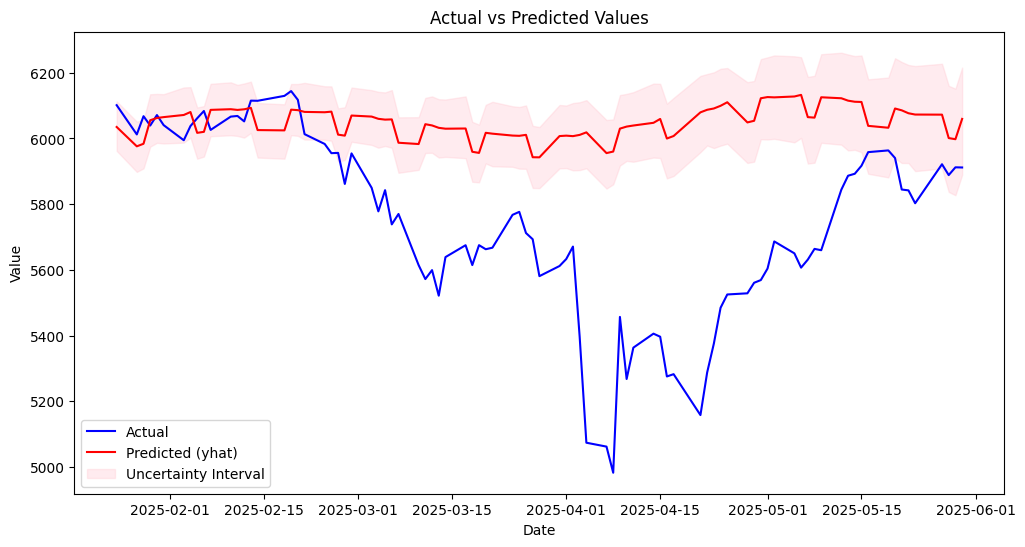

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(test['ds'], test['y'], label='Actual', color='blue')
plt.plot(test['ds'], predicted_forecast['yhat'], label='Predicted (yhat)', color='red')
plt.fill_between(test['ds'], predicted_forecast['yhat_lower'], predicted_forecast['yhat_upper'], color='pink', alpha=0.3, label='Uncertainty Interval')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()


In [ ]:
forecast.iloc[600:,:]


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
600,2025-05-24,5786.418978,5582.286142,5817.345778,5786.418978,5786.418978,-81.720991,-81.720991,-81.720991,-2.366042,-2.366042,-2.366042,-79.354949,-79.354949,-79.354949,0.0,0.0,0.0,5704.697986
601,2025-05-25,5785.777509,5582.388692,5806.739301,5785.777509,5785.777509,-82.988269,-82.988269,-82.988269,-2.366049,-2.366049,-2.366049,-80.622221,-80.622221,-80.622221,0.0,0.0,0.0,5702.789240
602,2025-05-26,5785.136040,5585.954109,5809.530712,5785.136040,5785.136040,-82.223242,-82.223242,-82.223242,-0.661355,-0.661355,-0.661355,-81.561888,-81.561888,-81.561888,0.0,0.0,0.0,5702.912798
603,2025-05-27,5784.494571,5597.297797,5824.325935,5784.494571,5784.494571,-81.807108,-81.807108,-81.807108,0.247129,0.247129,0.247129,-82.054237,-82.054237,-82.054237,0.0,0.0,0.0,5702.687463
604,2025-05-28,5783.853103,5595.798923,5817.352089,5783.853103,5783.853103,-80.076144,-80.076144,-80.076144,1.921295,1.921295,1.921295,-81.997438,-81.997438,-81.997438,0.0,0.0,0.0,5703.776959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,2025-10-26,5686.991318,5191.989875,6104.824372,5269.093779,6168.376029,-74.601962,-74.601962,-74.601962,-2.366049,-2.366049,-2.366049,-72.235913,-72.235913,-72.235913,0.0,0.0,0.0,5612.389355
756,2025-10-27,5686.349849,5179.627556,6124.300911,5262.801697,6173.405694,-71.666744,-71.666744,-71.666744,-0.661355,-0.661355,-0.661355,-71.005389,-71.005389,-71.005389,0.0,0.0,0.0,5614.683105
757,2025-10-28,5685.708380,5188.997119,6111.476908,5258.563320,6178.313668,-68.436147,-68.436147,-68.436147,0.247129,0.247129,0.247129,-68.683276,-68.683276,-68.683276,0.0,0.0,0.0,5617.272233
758,2025-10-29,5685.066911,5169.137414,6144.871766,5254.098388,6182.202365,-63.373288,-63.373288,-63.373288,1.921295,1.921295,1.921295,-65.294583,-65.294583,-65.294583,0.0,0.0,0.0,5621.693623
